$$
\frac{du_h}{dt} = (\mu_1 - \xi_h u_m) (1 - u_h - u_d - u_s)u_h + \alpha \gamma u_a u_s - \nu_1 u_h - \delta_h u_m u_h,
$$
$$
\frac{du_d}{dt} = (\mu_2 - \xi_в u_m) (1 - u_h - u_d - u_s)u_d + (1 - \alpha) \gamma u_a u_s - \nu_2 u_d - \delta_d u_m u_d,
$$
$$
\frac{du_s}{dt} = (\mu_3 - \xi_s u_m) (1 - u_h - u_d - u_s)u_s^2 - \gamma u_a u_s - \delta_s u_m u_s,
$$
$$
\frac{du_a}{dt} = -\mu_4 u_a (\beta - u_s).
$$
$$
\frac{du_m}{dt} = \kappa - \lambda u_m.
$$


In [63]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.optimize import minimize
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm

In [68]:
alpha = 0.5

# Параметры
params = {
    'mu1': 1, 'mu2': 1.5, 'mu3': 0.1, 'mu4': 0.1,
    'alpha': 0.2, 'beta': 0.35, 'gamma': 0.2,
    'nu1': 0.1, 'nu2': 0.1,
    'kappa': 0.1, 'lambd': 0.1,
    'delta_h': 0.2, 'delta_d': 0.5, 'delta_s': 0.05,     # Скорость воздействия медикаментов на клетки
    'xi_h': 0.2, 'xi_d': 0.5, 'xi_s': 0.05,              # Коэффициенты влияния медикаментов на скорость размножения клеток
    't1': 50, 't2': 150
}

# Временные параметры
T = 10  # конечное время
dt = 0.1  # шаг времени
time_steps = int(T / dt)
times = np.linspace(0, T, time_steps)

In [54]:
# Функция динамики системы
def dynamics(state, t, u_func):
    u = u_func(t)
    _uh, _ud, _us, _ua, _um = state

    dudt = [
        (params['mu1'] - params['xi_h'] * _um) * (1 - _uh - _ud - _us) * _uh + params['alpha'] * params['gamma'] * _ua * _us - params['nu1'] * _uh - params['delta_h'] * _um * _uh,
        (params['mu2'] - params['xi_d'] * _um) * (1 - _uh - _ud - _us) * _ud + (1 - params['alpha']) * params['gamma'] * _ua * _us - params['nu2'] * _ud - params['delta_d'] * _um * _ud,
        (params['mu3'] - params['xi_s'] * _um) * (1 - _uh - _ud - _us) * _us ** 2 - params['gamma'] * _ua * _us - params['delta_s'] * _um * _us,
        -params['mu4'] * _ua * (params['beta'] - _us),
        u - params['lambd'] * _um 
    ]
    # Ограничение значений чтобы не было отрицательных значений
    if _uh + dudt[0] < 0:
        dudt[0] = -_uh
    if _ud + dudt[1] < 0:
        dudt[1] = -_ud
    if _us + dudt[2] < 0:
        dudt[2] = -_us
    if _ua + dudt[3] < 0:
        dudt[3] = -_ua
    if _um + dudt[4] < 0:
        dudt[4] = -_um
    # Ограничение значений чтобы не было значений больше 1        
    if _uh + dudt[0] > 1:
        dudt[0] = 1 - _uh
    if _ud + dudt[1] > 1:
        dudt[1] = 1 - _ud
    if _us + dudt[2] > 1:
        dudt[2] = 1 - _us
    if _ua + dudt[3] > 1:
        dudt[3] = 1 - _ua
    if _um + dudt[4] > 1:
        dudt[4] = 1 - _um
    return dudt

In [65]:
# Начальные условия
uh, ud, us, ua, um = 0.55, 0.03, 0.1, 0.2, 0
initial_state = [uh, ud, us, ua, um]

In [56]:
# Функция стоимости
def cost(u, initial_state, times):
    u_func = interp1d(times, u, bounds_error=False, fill_value=(u[0], u[-1]))
    solution = odeint(dynamics, initial_state, times, args=(u_func,))
    C = solution[:, 1]
    return np.sum(C + alpha * u**2)

In [69]:
# Инициализация управления
initial_guess = np.zeros(time_steps)

# Оптимизация управления
result = minimize(cost, initial_guess, args=(initial_state, times), method='L-BFGS-B', bounds=[(0, 1)] * time_steps)

# Оптимальное управление
optimal_u = result.x

# Решение системы с оптимальным управлением
optimal_u_func = interp1d(times, optimal_u, bounds_error=False, fill_value=(optimal_u[0], optimal_u[-1]))
optimal_solution = odeint(dynamics, initial_state, times, args=(optimal_u_func,))

# Визуализация результатов
N = optimal_solution[:, 0]
C = optimal_solution[:, 1]
S = optimal_solution[:, 2]
E = optimal_solution[:, 3]
H = optimal_solution[:, 4]

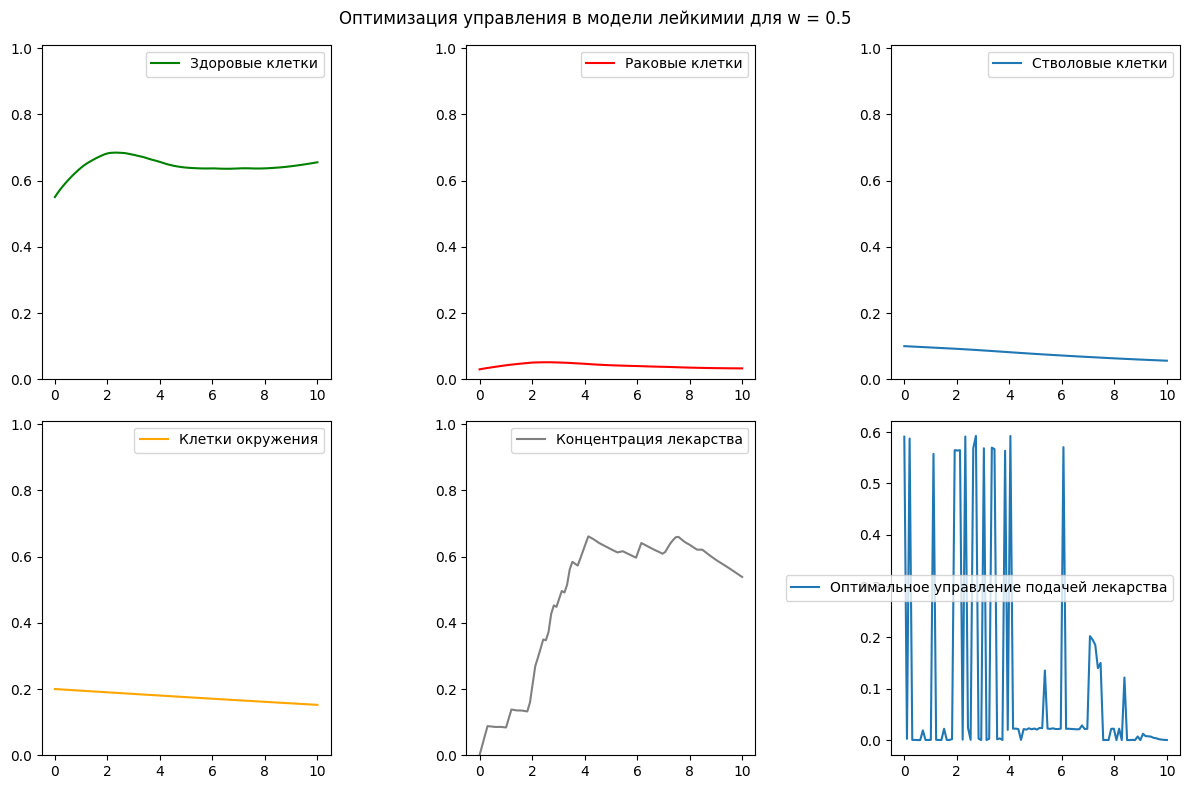

In [70]:
plt.figure(figsize=(12, 8))
plt.suptitle('Оптимизация управления в модели лейкимии для w = 0.5')
plt.subplot(2, 3, 1)
plt.plot(times, N, label='Здоровые клетки', color='green')
plt.legend()
plt.ylim(0, 1.01)

plt.subplot(2, 3, 2)
plt.plot(times, C, label='Раковые клетки', color='red')
plt.legend()
plt.ylim(0, 1.01)

plt.subplot(2, 3, 3)
plt.plot(times, S, label='Стволовые клетки')
plt.legend()
plt.ylim(0, 1.01)

plt.subplot(2, 3, 4)
plt.plot(times, E, label='Клетки окружения', color='orange')
plt.legend()
plt.ylim(0, 1.01)

plt.subplot(2, 3, 5)
plt.plot(times, H, label='Концентрация лекарства', color='gray')
plt.legend()
plt.ylim(0, 1.01)

plt.subplot(2, 3, 6)
plt.plot(times, optimal_u, label='Оптимальное управление подачей лекарства')
plt.legend()

plt.tight_layout()
plt.savefig('leikimia_optimise05.png')
plt.show()

In [71]:
for i in tqdm(range(1,10)):
    alpha = i / 10

    # Инициализация управления
    initial_guess = np.zeros(time_steps)
    
    # Оптимизация управления
    result = minimize(cost, initial_guess, args=(initial_state, times), method='L-BFGS-B', bounds=[(0, 1)] * time_steps)
    
    # Оптимальное управление
    optimal_u = result.x
    
    # Решение системы с оптимальным управлением
    optimal_u_func = interp1d(times, optimal_u, bounds_error=False, fill_value=(optimal_u[0], optimal_u[-1]))
    optimal_solution = odeint(dynamics, initial_state, times, args=(optimal_u_func,))
    
    # Визуализация результатов
    N = optimal_solution[:, 0]
    C = optimal_solution[:, 1]
    S = optimal_solution[:, 2]
    E = optimal_solution[:, 3]
    H = optimal_solution[:, 4]
    
    
    plt.figure(figsize=(12, 8))
    plt.suptitle('Оптимизация управления в модели лейкимии для w = ' + str(alpha))
    plt.subplot(2, 3, 1)
    plt.plot(times, N, label='Здоровые клетки', color='green')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.plot(times, C, label='Раковые клетки', color='red')
    plt.legend()
    
    plt.subplot(2, 3, 3)
    plt.plot(times, S, label='Стволовые клетки')
    plt.legend()
    
    plt.subplot(2, 3, 4)
    plt.plot(times, E, label='Клетки окружения', color='orange')
    plt.legend()
    
    plt.subplot(2, 3, 5)
    plt.plot(times, H, label='Концентрация лекарства', color='gray')
    plt.legend()
    
    plt.subplot(2, 3, 6)
    plt.plot(times, optimal_u, label='Оптимальное управление подачей лекарства')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('leikimia_optimise0' + str(i) + '.png')
    plt.close()

100%|██████████| 9/9 [1:11:32<00:00, 476.92s/it]
